<a href="https://colab.research.google.com/github/jnshsrs/image_augmentation/blob/main/dfu_image_augmentation_pipelinew_with_working_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-nxl8vcr5
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-nxl8vcr5
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=97039 sha256=cafdd0253c13f64e8d836c0e1c5e40aba0a53f33a64323abef975781238d8aaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-di6dpjc3/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
from google.colab import drive
drive.mount('/content/diabetic-foot-ulcer')

Drive already mounted at /content/diabetic-foot-ulcer; to attempt to forcibly remount, call drive.mount("/content/diabetic-foot-ulcer", force_remount=True).


In [ ]:
%matplotlib inline

import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
import xml.etree.ElementTree as ET

def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes


In [ ]:
# Cat Ids
category_ids = [1]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {1: 'dfu'}

p = "/content/diabetic-foot-ulcer/MyDrive/images-annotated/"

import os

files = []
for file in os.listdir(p):
    if file.endswith(".xml"):
        files.append(os.path.join(p, file))

file = files[1]

print(file)

name, bboxes = read_content(file)
print(name)

image = cv2.imread(p + name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

dim = (800, 800)
class_labels = [1]

from google.colab.patches import cv2_imshow

# resize image
# image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cv2_imshow(image)

print(image.shape)


/content/diabetic-foot-ulcer/MyDrive/images-annotated/0011_5da118d2a6.xml
0011_5da118d2a6.jpg
(2560, 1920, 3)


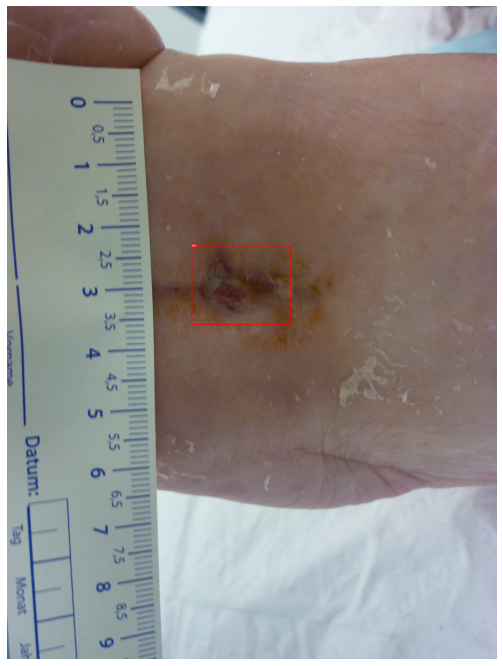

In [ ]:
visualize(image, bboxes = bboxes, category_ids = [1], category_id_to_name = category_id_to_name)

In [ ]:
trans = [
    A.Resize(800, 800),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, always_apply=True), 
    A.HueSaturationValue(always_apply=True, hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10),
    A.GaussianBlur(blur_limit=3, p=.2),
    A.MedianBlur(blur_limit=3, p=.2),
    A.RandomBrightnessContrast(brightness_limit=.2, contrast_limit=.2, p=1),
    A.ShiftScaleRotate(p=1),
    A.Rotate(p=.8),
    A.HorizontalFlip(always_apply=True)]

transform = A.Compose(
    trans,
    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['class_labels']),
)


trans_resize = [A.Resize(800, 800)]
transform_resize = A.Compose(trans_resize, bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3, label_fields=['class_labels']))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1852: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [ ]:
pip install pascal-voc-writer

In [ ]:
# Writer(path, width, height)
from pascal_voc_writer import Writer
def write_yolo_augmented(bboxes, path, image_name, transformed_image):

  writer = Writer(p + image_name + ".jpg", transformed_image.shape[0], transformed_image.shape[1])

  for i in range(len(bboxes)):
    xmin, ymin, xmax, ymax = bboxes[i]
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    label = transformed_labels[i]
    writer.addObject(label, xmin, ymin, xmax, ymax)

  writer.save(path + image_name + ".xml")

In [ ]:
s = "/content/diabetic-foot-ulcer/MyDrive/diabetic-foot-ulcer/0118_8064c9800a.xml"


In [ ]:
s

'/content/diabetic-foot-ulcer/MyDrive/diabetic-foot-ulcer/0118_8064c9800a.xml'